#1 Input file format for linear modelling

In this section, we read the globalbedo (MERIS and VGT) data do a brief examination of the data.

In particular. we are concerned with putting the data in a format that simplifies GA processing.

The first stage of this requires the observation and other data to be stacked into netcdf files with data of shape `(Nt,Nx,Ny)` where `Nt` is the number of time samples, and `Nx` and `Ny` are the spatial dimensions. We also define `time` as the number of days after a baseline (Jan 1 1998 here).

The input data are currently in netcdf files of form `rootgrp.variables[Nt][Nx,Ny]`.

We use the script [convertMe.py](convertMe.py) to achieve the conversion, and also to convert all 'standard deviation' or 'variance' files to weights (i.e. $\frac{1}{sd^2}$).

It assumes that the filenames are as currently supplied, and that all data are in a directory [`data`](data). It writes the re-formatted data to [`inputs`](inputs). This script should be modified to run on all supplied netcdf input data files.

The real reason for doing this is that when we open the new data files, we are able (if needed) tp memory-mapped in the python code, so, assuming the data are on a relatively fast (e.g. local, e.g. SSD) disk, the data access is greatly speeded up and memory requirements reduced. This is important when dealing with *very large* datasets.

There is generally a limit on the number of files that can be opened by a single process (typically 256). When using memory mapped files, we must make sure we close the files when we no longer need access to the data. We should really do this anyway, but it often becomes important in cases like this.

A potential issue is that the files created might well be of size > 2GB, which some operating systems may have a problem with. The answer is to use a better operating system.

We will now read some example files:

In [ ]:
"""
base = 'http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY'

#for s in ['priorOld','prior']:
for s in ['prior']:
    #for dtype in ['prior.1km.NoSnow', 'prior.1km.Snow', 'prior.1km.merge']:
    for dtype in ['prior.1km.NoSnow']:
        sensor = s + '/' + dtype
        for tile in ['h19v08..600_600..64_64']: 
            ''',\
                     'h22v02..600_600..256_256','h25v06..600_600..256_256']:'''
            print s,dtype,tile
            !pushd /Volumes/Data; \
                wget -q -r -nc $base/$sensor/$tile
"""

In [ ]:
"""
base = 'http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY'

for sensor in ['bbdr.meris', 'bbdr.vgt']:
    for tile in ['h18v04..600_600..256_256','h19v08..600_600..256_256',\
                 'h22v02..600_600..256_256','h25v06..600_600..256_256']:
        !pushd /space/ucfamv0/Projects/15_QA4ECV; \
            wget -q -r -nc -np $base/$sensor/$tile
      
s = 'ga.brdf'
for dtype in ['ga.brdf.NoSnow', 'ga.brdf.Snow', 'ga.brdf.merge']:
    sensor = s + '/' + dtype
    for tile in ['h18v04..600_600..256_256','h19v08..600_600..256_256',\
                 'h22v02..600_600..256_256','h25v06..600_600..256_256']:
        !pushd /space/ucfamv0/Projects/15_QA4ECV; \
            wget -q -r -nc -np $base/$sensor/$tile
            
s = 'prior'
for dtype in ['prior.1km.NoSnow', 'prior.1km.Snow', 'prior.1km.merge']:
    sensor = s + '/' + dtype
    for tile in ['h18v04..600_600..256_256','h19v08..600_600..256_256',\
                 'h22v02..600_600..256_256','h25v06..600_600..256_256']:
        !pushd /space/ucfamv0/Projects/15_QA4ECV; \
            wget -q -r -nc $base/$sensor/$tile

/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
^C/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
^C/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
^C/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
^C/space/ucfamv0/Projects/15_QA4ECV /space/ucfamv0/Projects/15_QA4ECV/code
/space/ucfamv0/Projects/15_QA4ECV /space/uc

In [2]:
run convertMe.py

ImportError: No module named spectral.io.envi

In [2]:
%matplotlib inline 

import numpy as np
import scipy
import pylab as plt
import numpy.ma as ma
import datetime
import glob
# easy_install spectral
import spectral.io.envi as envi
import os.path

def doy2date(doys,baseyear=1998):
    doys = doys[:]
    # convert doys list to date field
    year = baseyear
    return np.array([datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1) \
                   for doy in doys])

# set up some dictionaries to access the data
data = {}

def readenvi(m_files): 
    data = {'data':[],'rootgrp':[],'time':[],'baseyear':[],'filenames':[],'sensor':[]}
    for i in xrange(len(m_files)):
        data['rootgrp'].append(envi.open (m_files[i]))
        rootgrp = data['rootgrp'][-1]
        data['data'].append(rootgrp.open_memmap())
        data['time'] = np.array(rootgrp.metadata['time']).astype(float)
        data['baseyear'].append(int(rootgrp.metadata['baseyear']))
        data['sensor'].append(rootgrp.metadata['sensor'])
        data['filenames'].append(m_files[i])
    return data

def plotdata(data,log=False,band=0,set=0,row=0,col=0):
    sensor = data['sensor'][set]
    print len(data['data']),data['data'][set].shape
    plt.figure(figsize=(15,8))
    plt.title(sensor)
    if log: 
        plt.imshow(np.log(data['data'][set][:,:,band]),interpolation='nearest')
    else:
        plt.imshow(data['data'][set][:,:,band],interpolation='nearest')
    plt.colorbar()
    plt.figure(figsize=(15,8))
    plt.plot(doy2date(data['time'],baseyear=data['baseyear'][set]),data['data'][set][row,col,:],'r+')
    if log: plt.semilogy()


In [3]:
pathname = '/space/ucfamv0/Projects/15_QA4ECV/inputs/'
for sensor in ['meris', 'vgt']:
  for tile in ['h18v04', 'h19v08', 'h22v02', 'h25v06']:
    
    info = {'tile':tile,'sizer':'256','sensor':sensor}

    m_files = [pathname + 'bbdr.{sensor}..BB_NIR..{tile}..600_600..{sizer}_{sizer}.hdr'.format(**info),\
               pathname + 'bbdr.{sensor}..Kvol_BRDF_NIR..{tile}..600_600..{sizer}_{sizer}.hdr'.format(**info),\
               pathname + 'bbdr.{sensor}..Kgeo_BRDF_NIR..{tile}..600_600..{sizer}_{sizer}.hdr'.format(**info),\
               pathname + 'bbdr.{sensor}..weight_BB_NIR_NIR..{tile}..600_600..{sizer}_{sizer}.hdr'.format(**info),\
               pathname + 'bbdr.{sensor}..snow_mask..{tile}..600_600..{sizer}_{sizer}.hdr'.format(**info)]
    data[sensor] = readenvi(m_files)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207


KeyboardInterrupt: 

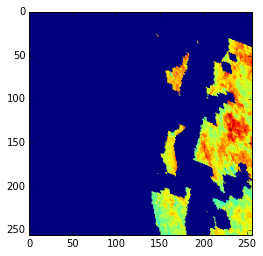

In [83]:
data.keys()
a = data['meris']['data'][0]
for i in range(2998):
    print i
    plt.imshow(a[:,:,i])
    plt.savefig('/space/ucfamv0/Projects/15_QA4ECV/img/%s.png' % i)

5 (256, 256, 2998)


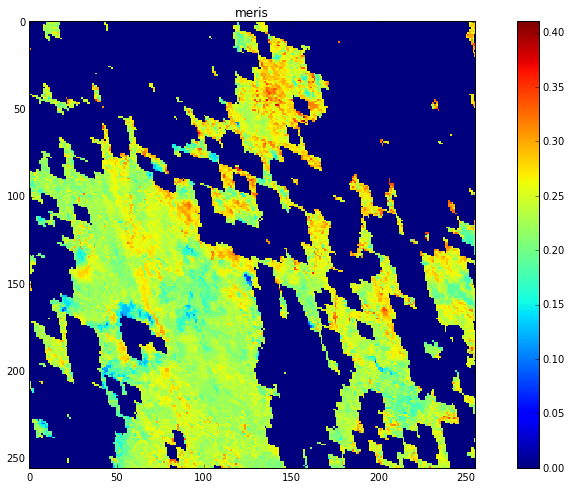

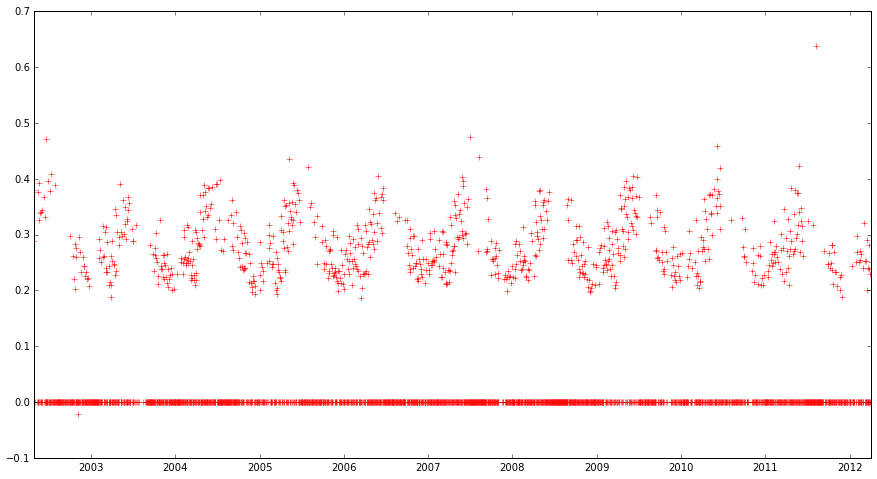

In [8]:
plotdata(data['meris'],set=0,band=-1000,col=30,row=30)

5 (256, 256, 2998)


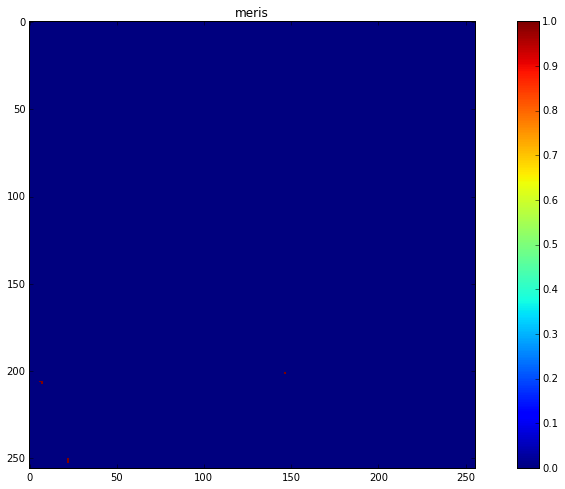

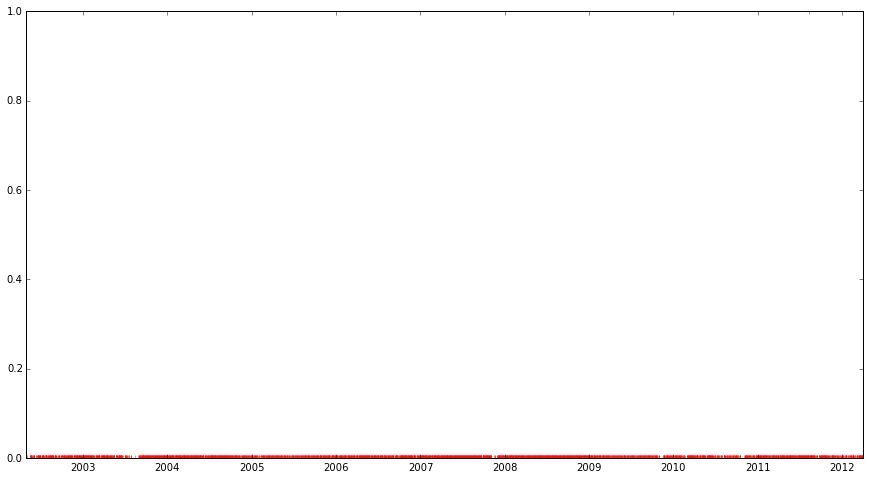

In [9]:
plotdata(data['meris'],set=4,band=-1000,col=30,row=30)

5 (256, 256, 3730)


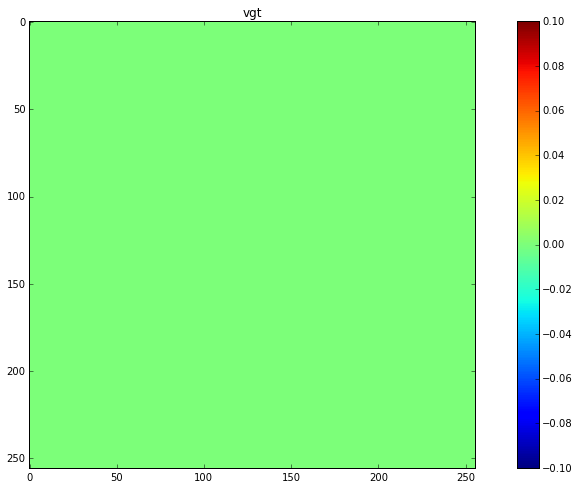

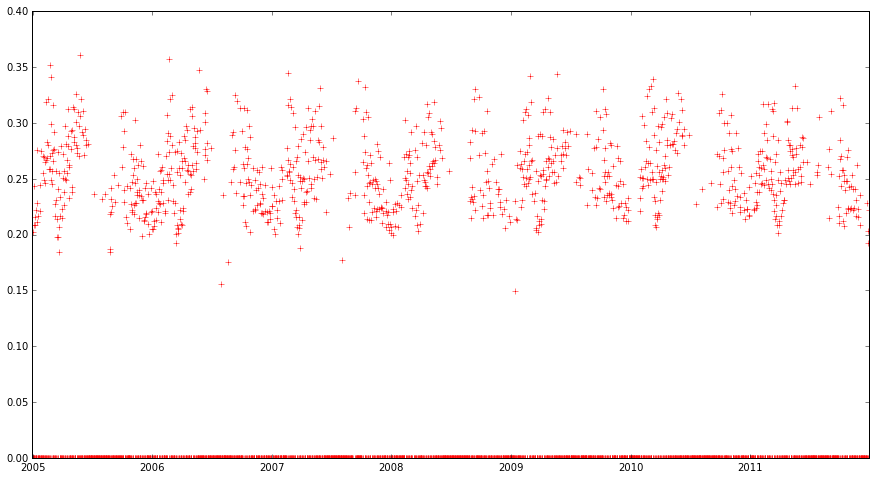

In [10]:
plotdata(data['vgt'],set=0,band=-10,col=50,row=125)

5 (256, 256, 3730)


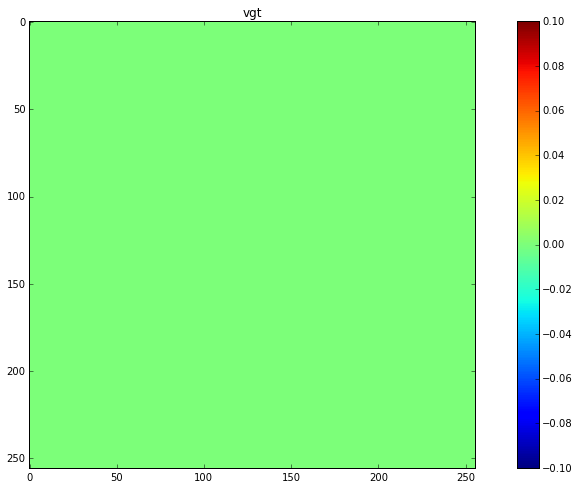

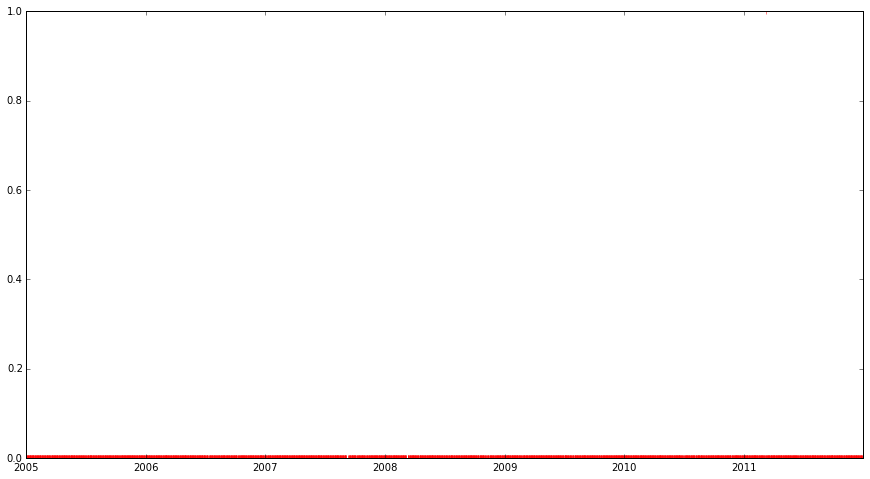

In [11]:
plotdata(data['vgt'],set=4,band=-10,col=50,row=125)

1 (256, 256, 644)


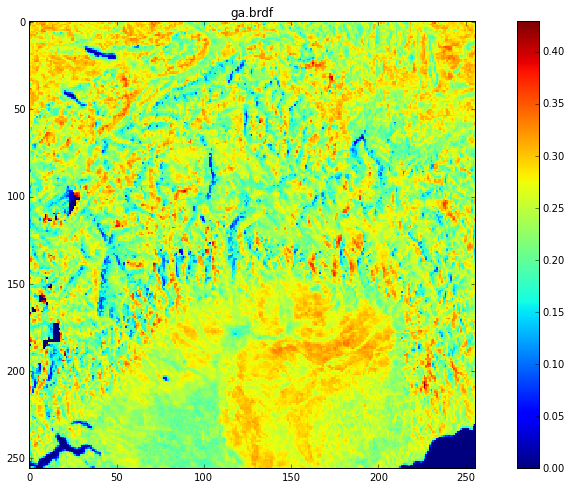

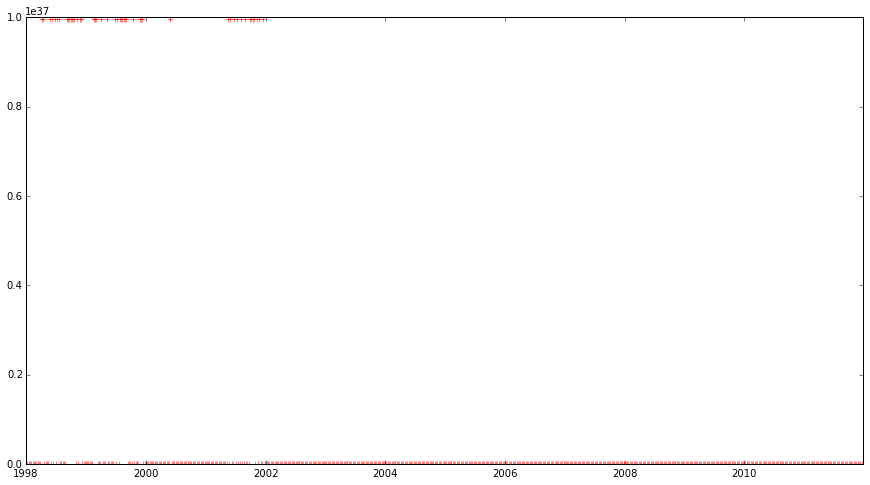

In [12]:
pathname = '/space/ucfamv0/Projects/15_QA4ECV/inputs/'
ga_files = np.sort(glob.glob(pathname + 'ga.brdf.NoSnow..mean_NIR_f0..h18v04..600_600..256_256.hdr'))

data['ga mean'] = readenvi(ga_files)

plotdata(data['ga mean'],set=0,band=7,col=50,row=125)

3 (256, 256, 644)


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


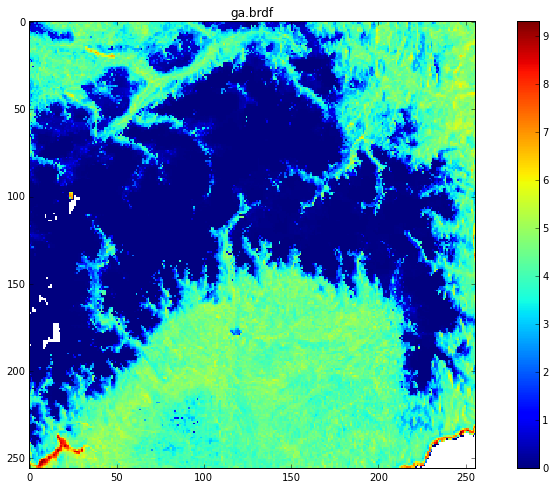

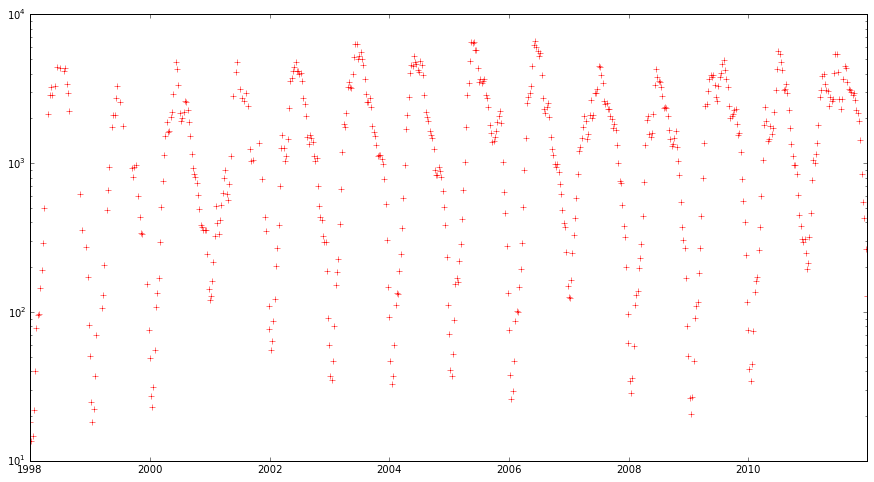

In [14]:
pathname = '/space/ucfamv0/Projects/15_QA4ECV/inputs/'
gawt_files = [pathname + 'ga.brdf.NoSnow..weight_NIR_f{0}_NIR_f{0}..h18v04..600_600..256_256.hdr'\
              .format(i) for i in xrange(3)]

data['ga weight'] = readenvi(gawt_files)

plotdata(data['ga weight'],set=0,band=1,log=True)

3 (256, 256, 46)


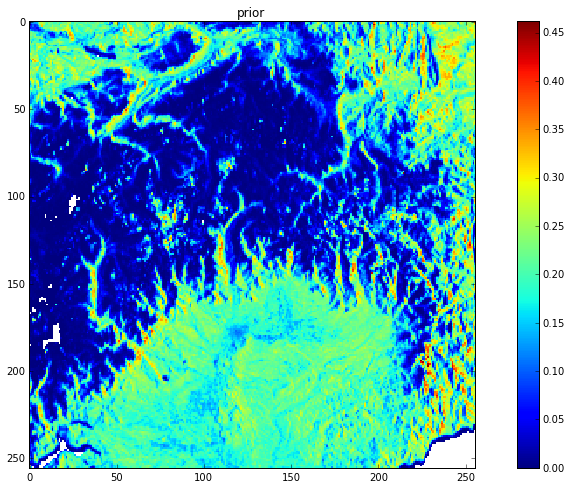

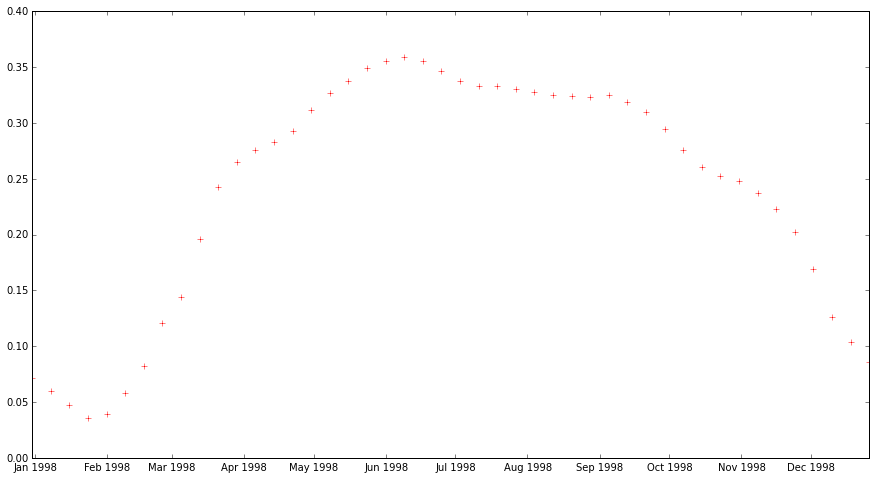

In [15]:
pathname = '/space/ucfamv0/Projects/15_QA4ECV/inputs/'
pws_files = np.sort(glob.glob(pathname + 'prior.1km.NoSnow..MEAN:_BAND_8_PARAMETER_F?..h18v04..600_600..256_256.hdr'))

data['prior mean'] = readenvi(pws_files)

plotdata(data['prior mean'],set=0,band=0)

3 (256, 256, 46)


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


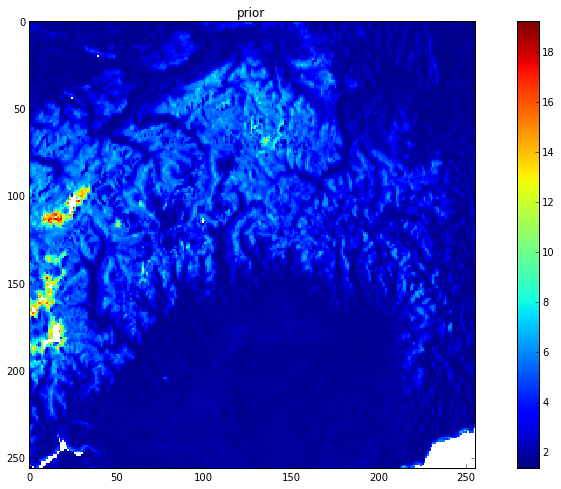

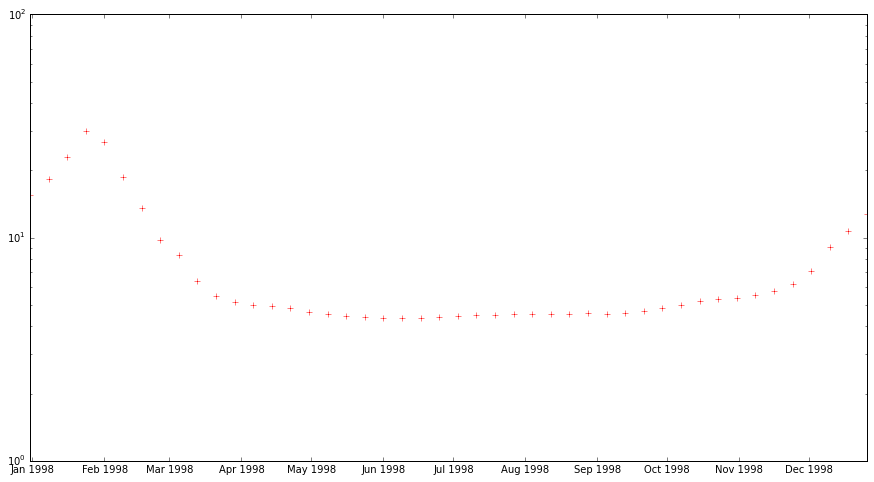

In [16]:
pathname = '/space/ucfamv0/Projects/15_QA4ECV/inputs/'
spws_files = np.sort(glob.glob(pathname + 'prior.1km.NoSnow..weight:_BAND_8_PARAMETER_F?..h18v04..600_600..256_256.hdr'))

data['prior weight'] = readenvi(spws_files)

plotdata(data['prior weight'],set=0,band=0,log=True)

In [17]:
# tidy up
for k in data.keys():
    nd = data[k]['data']
    for kk in data[k].keys():
        del kk
    del k
del data